In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muniryadi/cat-vs-rabbit")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\07020\.cache\kagglehub\datasets\muniryadi\cat-vs-rabbit\versions\4


In [2]:
# Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [5]:
import timeit

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6057302000117488


In [8]:
# ImageDataGenerator
train_path = "C:/Users/07020/.cache/kagglehub/datasets/muniryadi/cat-vs-rabbit/versions/4/train-cat-rabbit/"
val_path = "C:/Users/07020/.cache/kagglehub/datasets/muniryadi/cat-vs-rabbit/versions/4/val-cat-rabbit/"


train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   )
val_datagen = ImageDataGenerator(rescale=1./255)


# Configuramos el generador
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary')

train_generator

Found 1600 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


In [9]:
len(train_generator.class_indices)

2

In [10]:
train_generator.image_shape

(100, 100, 3)

In [11]:
# Configuración del modelo
input_shape = train_generator.image_shape

num_classes = 1 # len(train_generator.class_indices)

model = Sequential([
    Input(shape=input_shape),

    # Conv
    Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    # Segindo bloque
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Tercer bloque
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten
    Flatten(),

    # Dense
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="sigmoid")
])

c:\Users\07020\Dev\curso_ml\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compilación y resumen
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape       ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)       │ (None, 98, 98, 32) │        896 │
├──────────────────────────┼────────────────────┼────────────┤
│ max_pooling2d            │ (None, 49, 49, 32) │          0 │
│ (MaxPooling2D)           │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ conv2d_23 (Conv2D)       │ (None, 47, 47, 64) │     18,496 │
├──────────────────────────┼────────────────────┼────────────┤
│ max_pooling2d_1          │ (None, 23, 23, 64) │          0 │
│ (MaxPooling2D)           │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ conv2d_24 (Conv2D)       │ (None, 21, 21,     │     73,856 │
│                          │ 128)               │            │
├──────────────────────────┼────────────────────┼────────────┤
│ max_pooling2d_2          │ (None, 10, 10,     │          0 │
│ (MaxPooling2D)           │ 128)               │            │
├──────────────────────────┼────────────────────┼────────────┤
│ flatten (Flatten)        │ (None, 12800)      │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense (Dense)            │ (None, 32)         │    409,632 │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout (Dropout)        │ (None, 32)         │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_1 (Dense)          │ (None, 1)          │         33 │
└──────────────────────────┴────────────────────┴────────────┘

 Total params: 502,913 (1.92 MB)

 Trainable params: 502,913 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Entrenamos
with tf.device('/GPU:0'):
  history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples,
      epochs=50,
      validation_data=val_generator,
      validation_steps=val_generator.samples
  )

Epoch 1/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8175 - loss: 0.4001 - val_accuracy: 0.8261 - val_loss: 0.4025
Epoch 2/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8146 - loss: 0.4097 - val_accuracy: 0.7995 - val_loss: 0.3869
Epoch 3/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8344 - loss: 0.3843 - val_accuracy: 0.8406 - val_loss: 0.3577
Epoch 4/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8415 - loss: 0.3531 - val_accuracy: 0.8357 - val_loss: 0.3833
Epoch 5/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8485 - loss: 0.3700 - val_accuracy: 0.8382 - val_loss: 0.3920
Epoch 6/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8388 - loss: 0.3539 - val_accuracy: 0.8478 - val_loss: 0.3675
Epoch 7/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8516 - loss: 0.3375 - val_accuracy: 0.8527 - val_loss: 0.3442
Epoch 8/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.8390 - loss: 0.3660 

In [15]:
model.evaluate(val_generator)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9087 - loss: 0.3073


[0.32017892599105835, 0.9009661674499512]

In [16]:
# Evaluacion del conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validación Acc: {val_acc:.3f}")
print(f"Validación Loss: {val_loss:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8789 - loss: 0.3690
Validación Acc: 0.901
Validación Loss: 0.320


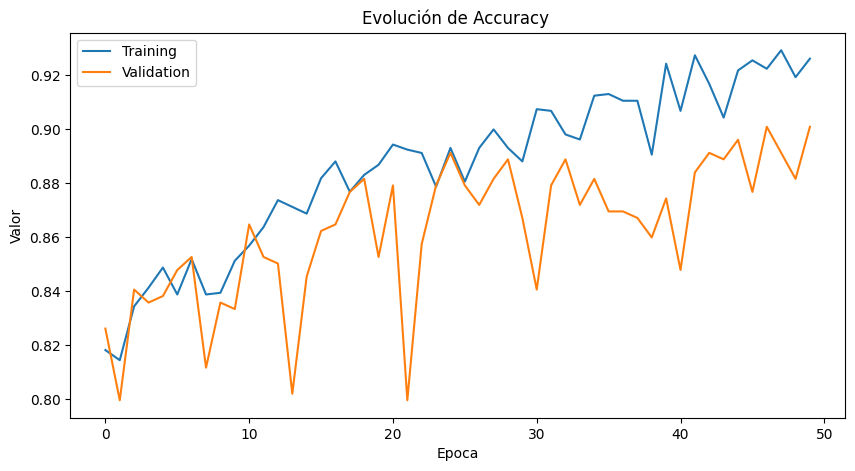

In [17]:
import matplotlib.pyplot as plt

# Graficamos
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Evolución de Accuracy ")
plt.xlabel("Epoca")
plt.ylabel("Valor")
plt.legend()
plt.show()

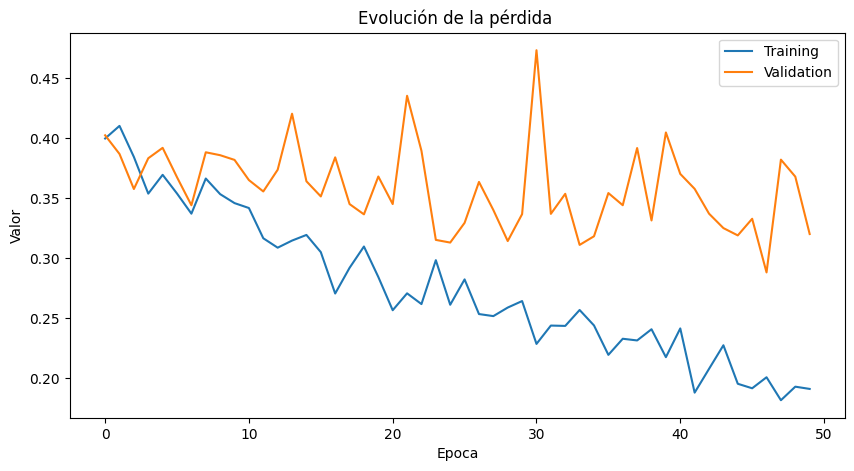

In [18]:
# Graficamos
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Evolución de la pérdida ")
plt.xlabel("Epoca")
plt.ylabel("Valor")
plt.legend()
plt.show()

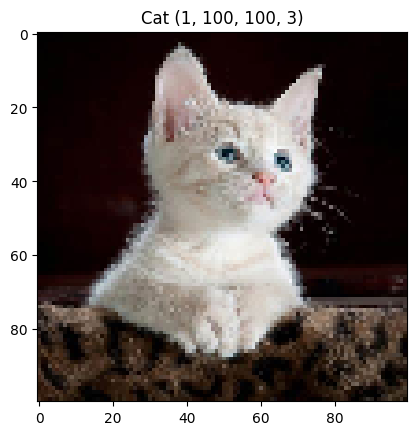

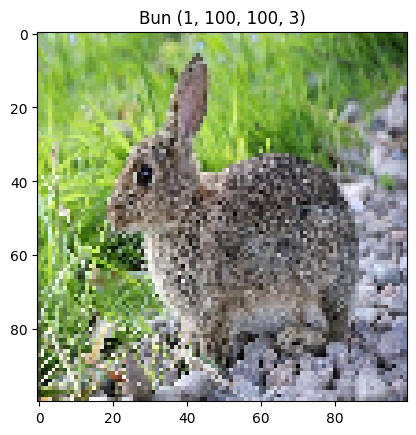

In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Creamos una función para cargar la nueva imagen
def load_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    return img


# Cargamos la imagen
cat_path = "./cat.jpg"
bun_path = "./conejo.jpg"

cat_img = load_image(cat_path, (100, 100))
bun_img = load_image(bun_path, (100, 100))

plt.imshow(cat_img[0]); plt.title(f"Cat {cat_img.shape}");plt.show()
plt.imshow(bun_img[0]); plt.title(f"Bun {cat_img.shape}");plt.show()

In [25]:
train_generator.class_indices

class_labels = {0: "cat", 1: "bunny"}

In [26]:
pred = model.predict(cat_img)
pred_class = np.argmax(pred, axis=1)
print(f"Predicción: {class_labels[pred_class[0]]}; full: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicción: cat; full: [[0.78218025]]


In [27]:
pred = model.predict(bun_img)
pred_class = np.argmax(pred, axis=1)
print(f"Predicción: {class_labels[pred_class[0]]}; full: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicción: cat; full: [[0.9999992]]


In [28]:
dummy_input = np.zeros((1, 100, 100, 3))

# Call the model with dummy data to initialize the input shape
model(dummy_input)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [29]:
model.save("cat_vs_rabit.keras")

In [30]:
# Cargamos el modelo
new_model = tf.keras.models.load_model("cat_vs_rabit.keras")

new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape       ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)       │ (None, 98, 98, 32) │        896 │
├──────────────────────────┼────────────────────┼────────────┤
│ max_pooling2d            │ (None, 49, 49, 32) │          0 │
│ (MaxPooling2D)           │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ conv2d_23 (Conv2D)       │ (None, 47, 47, 64) │     18,496 │
├──────────────────────────┼────────────────────┼────────────┤
│ max_pooling2d_1          │ (None, 23, 23, 64) │          0 │
│ (MaxPooling2D)           │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ conv2d_24 (Conv2D)       │ (None, 21, 21,     │     73,856 │
│                          │ 128)               │            │
├──────────────────────────┼────────────────────┼────────────┤
│ max_pooling2d_2          │ (None, 10, 10,     │          0 │
│ (MaxPooling2D)           │ 128)               │            │
├──────────────────────────┼────────────────────┼────────────┤
│ flatten (Flatten)        │ (None, 12800)      │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense (Dense)            │ (None, 32)         │    409,632 │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout (Dropout)        │ (None, 32)         │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_1 (Dense)          │ (None, 1)          │         33 │
└──────────────────────────┴────────────────────┴────────────┘

 Total params: 1,508,741 (5.76 MB)

 Trainable params: 502,913 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,005,828 (3.84 MB)